In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind


# -------------------------------------------------------------
# 1. Learning Curves (Final Accuracy vs Budget) per Query Strategy
# -------------------------------------------------------------

def plot_learning_curves(df):
    plt.figure(figsize=(14, 8))
    sns.lineplot(
        data=df,
        x="budget",
        y="final_accuracy",
        hue="query_strategy",
        errorbar='sd',
        marker="o"
    )
    plt.title("Learning Curves per Query Strategy")
    plt.xlabel("Budget (%)")
    plt.ylabel("Final Accuracy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 2. Boxplot: Final Accuracy per Strategy
# -------------------------------------------------------------

def plot_strategy_boxplots(df):
    plt.figure(figsize=(16, 8))
    order = df.groupby("query_strategy")["final_accuracy"].mean().sort_values(ascending=False).index
    sns.boxplot(
        data=df,
        x="query_strategy",
        y="final_accuracy",
        order=order
    )
    plt.xticks(rotation=45)
    plt.title("Final Accuracy Distribution per Query Strategy")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 3. Accuracy Improvement Relative to Baseline (Random + Periodic / 2)
# -------------------------------------------------------------

def compute_baseline_diff(df):
    baseline_df = df[df["query_strategy"].isin(["RandomSampling", "PeriodicSampling"])]
    baseline_mean = baseline_df.groupby(["dataset", "model_name", "budget"])["final_accuracy"].mean().reset_index()
    baseline_mean = baseline_mean.rename(columns={"final_accuracy": "baseline_accuracy"})
    
    merged = df.merge(baseline_mean, on=["dataset", "model_name", "budget"], how="left")
    merged["accuracy_diff"] = merged["final_accuracy"] - merged["baseline_accuracy"]
    return merged

def plot_accuracy_diff(df):
    plt.figure(figsize=(16, 8))
    sns.boxplot(data=df, x="query_strategy", y="accuracy_diff")
    plt.axhline(0, color="black", linestyle="--")
    plt.xticks(rotation=45)
    plt.title("Accuracy Difference Relative to Baseline")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 4. Heatmap: Mean Accuracy per Model and Strategy
# -------------------------------------------------------------

def plot_heatmap_model_strategy(df):
    pivot = df.pivot_table(
        index="model_name",
        columns="query_strategy",
        values="final_accuracy",
        aggfunc="mean"
    )
    plt.figure(figsize=(18, 10))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Mean Final Accuracy per Model and Strategy")
    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 5. Per-Dataset Performance Comparison (grid)
# -------------------------------------------------------------

def plot_dataset_grid(df, n_cols=4):
    datasets = sorted(df["dataset"].unique())
    n_rows = int(np.ceil(len(datasets) / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows), sharey=True)

    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        subset = df[df["dataset"] == dataset]
        sns.lineplot(
            data=subset,
            x="budget",
            y="final_accuracy",
            hue="query_strategy",
            ax=axes[i],
            legend=False
        )
        axes[i].set_title(dataset)
        axes[i].set_ylim(df["final_accuracy"].min(), df["final_accuracy"].max())
        axes[i].grid(True)

    plt.suptitle("Learning Curves per Dataset", fontsize=18)
    plt.tight_layout()
    plt.show()

def unify_query_strategies(df):
    """
    Unifies 'PeriodicSampling' and 'StreamRandomSampling' strategies into a 
    single 'baseline' strategy by averaging their 'final_accuracy'.

    The grouping is performed based on all other columns except 'query_strategy' 
    and 'final_accuracy'.

    Args:
        df: The input DataFrame containing active learning experiment results.

    Returns:
        A new DataFrame with the unified 'baseline' strategy replacing the 
        two original strategies.
    """
    
    strategies_to_unify = ['PeriodicSampling', 'StreamRandomSampling']
    new_strategy_name = 'Baseline'

    all_cols = df.columns.tolist()
    
    required_cols = ['query_strategy', 'final_accuracy']
    if not all(col in all_cols for col in required_cols):
        raise ValueError(f"DataFrame must contain columns: {required_cols}")

    grouping_keys = [col for col in all_cols 
                     if col not in ['query_strategy', 'final_accuracy']]
    
    df_to_unify = df[df['query_strategy'].isin(strategies_to_unify)].copy()

    df_baseline = df_to_unify.groupby(grouping_keys, as_index=False)['final_accuracy'].mean()

    df_baseline['query_strategy'] = new_strategy_name
    
    df_baseline = df_baseline[all_cols]

    df_others = df[~df['query_strategy'].isin(strategies_to_unify)].copy()

    df_union_new = pd.concat([df_others, df_baseline], ignore_index=True)

    return df_union_new



def calculate_p_values(df_unified: pd.DataFrame) -> dict:
    """
    Calculates the two-sample independent t-test p-value for each query strategy 
    against the 'baseline' strategy, comparing their 'final_accuracy' populations.

    Args:
        df_unified: The DataFrame containing active learning results.

    Returns:
        A dictionary where keys are query strategies and values are their 
        calculated p-values against the baseline.
    """
    p_values = {}
    strategies = df_unified['query_strategy'].unique()
    
    # Extract the full population of baseline accuracies for comparison
    df_baseline_acc = df_unified[df_unified['query_strategy'] == 'Baseline']['final_accuracy']
    
    for strategy in strategies:
        if strategy == 'Baseline':
            p_values[strategy] = 1.0
            continue
        
        # Check if the baseline population is large enough for a t-test
        if len(df_baseline_acc) > 1:
            # Extract the full population of the current strategy's accuracies
            df_strategy_acc = df_unified[df_unified['query_strategy'] == strategy]['final_accuracy']
            
            # Check if the current strategy population is large enough for a t-test
            if len(df_strategy_acc) > 1:
                try:
                    # Perform an Independent Two-Sample T-Test (assuming unequal variances)
                    # We compare the entire accuracy distribution of each strategy to the baseline
                    stat, p = ttest_ind(df_strategy_acc, df_baseline_acc, equal_var=False)
                    p_values[strategy] = p
                except Exception:
                    # Catch any numerical errors during T-test calculation
                    p_values[strategy] = np.nan
            else:
                p_values[strategy] = np.nan # Not enough data in this strategy group
        else:
            p_values[strategy] = np.nan # Not enough data in baseline group

    print("\n--- Calculated P-Values (vs. Baseline) ---")
    print({k: f"{v:.4f}" if pd.notna(v) else "N/A" for k, v in p_values.items()})
    print("------------------------------------------")
    
    return p_values



def plot_accuracy_vs_budget(df_unified: pd.DataFrame, p_values: dict):
    """
    Plots final_accuracy vs. budget, applying custom styles to specific strategies
    and including the p-value (compared to baseline) in the legend.

    Args:
        df_unified: The DataFrame containing the unified active learning results.
        p_values: A dictionary of p-values for each strategy vs. baseline.
    """
    
    # 1. Prepare data for plotting: Calculate mean accuracy for each (strategy, budget) pair
    # This averages the accuracies for the line plot
    df_plot = df_unified.groupby(['query_strategy', 'budget'])['final_accuracy'].mean().reset_index()
    
    # Identify unique strategies for iterating and styling
    strategies = df_plot['query_strategy'].unique()

    # --- Setup Plot ---
    plt.figure(figsize=(10, 6))
    
    # Define custom styling and base labels
    CUSTOM_STYLES = {
        'Baseline': {'linestyle': ':', 'color': 'black', 'base_label': 'Baseline (Ref.)'}, 
        'NONE: BUDGET = 1': {'linestyle': '-', 'color': 'black', 'base_label': 'Full Budget'}
    }

    # Use a color palette for other strategies
    other_strategies = [s for s in strategies if s not in CUSTOM_STYLES]
    # Generate a color map for the remaining strategies
    colors = sns.color_palette("husl", len(other_strategies))
    color_map = {s: c for s, c in zip(other_strategies, colors)}
    
    # --- Plotting Loop ---
    for i, strategy in enumerate(strategies):
        subset = df_plot[df_plot['query_strategy'] == strategy]
        
        style = CUSTOM_STYLES.get(strategy, {})
        
        # Determine the base label, color, and linestyle
        if strategy in CUSTOM_STYLES:
            base_label = style['base_label']
            color = style['color']
            linestyle = style['linestyle']
        else:
            base_label = strategy
            color = color_map[strategy]
            linestyle = '-' # Solid line for all others

        # Construct the final label including the p-value
        p_value = p_values.get(strategy, np.nan)
        if strategy == 'baseline':
            final_label = base_label
        elif pd.notna(p_value):
            # Include p-value formatted to 3 decimal places
            final_label = f"{base_label} (p={p_value:.3f})"
        else:
            final_label = f"{base_label} (p=N/A)" # Handle cases with insufficient data

        plt.plot(
            subset['budget'], 
            subset['final_accuracy'], 
            label=final_label, 
            color=color, 
            linestyle=linestyle,
            marker='o', # Add markers for clarity
            linewidth=2
        )

    # --- Final Plot Customization ---
    
    # Set labels and title
    plt.title('Final Accuracy vs. Budget by Query Strategy', fontsize=16, fontweight='bold')
    plt.xlabel('Budget', fontsize=14)
    plt.ylabel('Final Accuracy', fontsize=14)
    
    # Add grid, legend, and context
    plt.grid(True, linestyle='--', alpha=0.6)
    # Updated legend title to reflect the p-value comparison
    plt.legend(title='Query Strategy (p-value vs. Baseline)', loc='lower right', frameon=True, shadow=True, fontsize=10)
    plt.minorticks_on()
    
    # Set y-axis limits to start from a reasonable minimum and end slightly above max accuracy
    max_acc = df_plot['final_accuracy'].max()
    min_acc = df_plot['final_accuracy'].min()
    plt.ylim(min_acc * 0.95, max_acc * 1.02)
    
    plt.tight_layout()
    plt.show()

# CC18

In [2]:
df_cc18 = pd.read_csv("../data/final_results/CC18_concat.csv")
df_cc18.drop(columns="Unnamed: 0", inplace=True)
df_cc18.shape

(19992, 8)

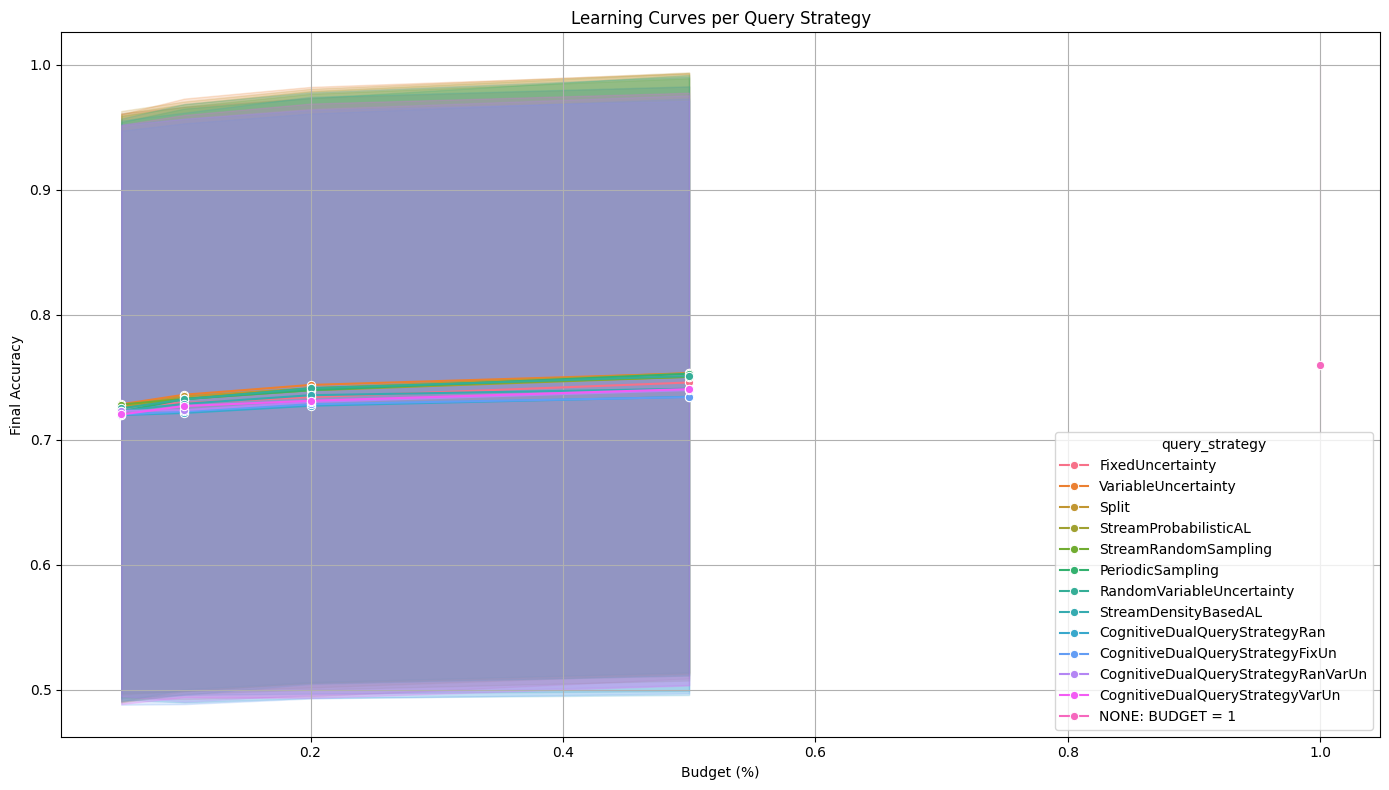

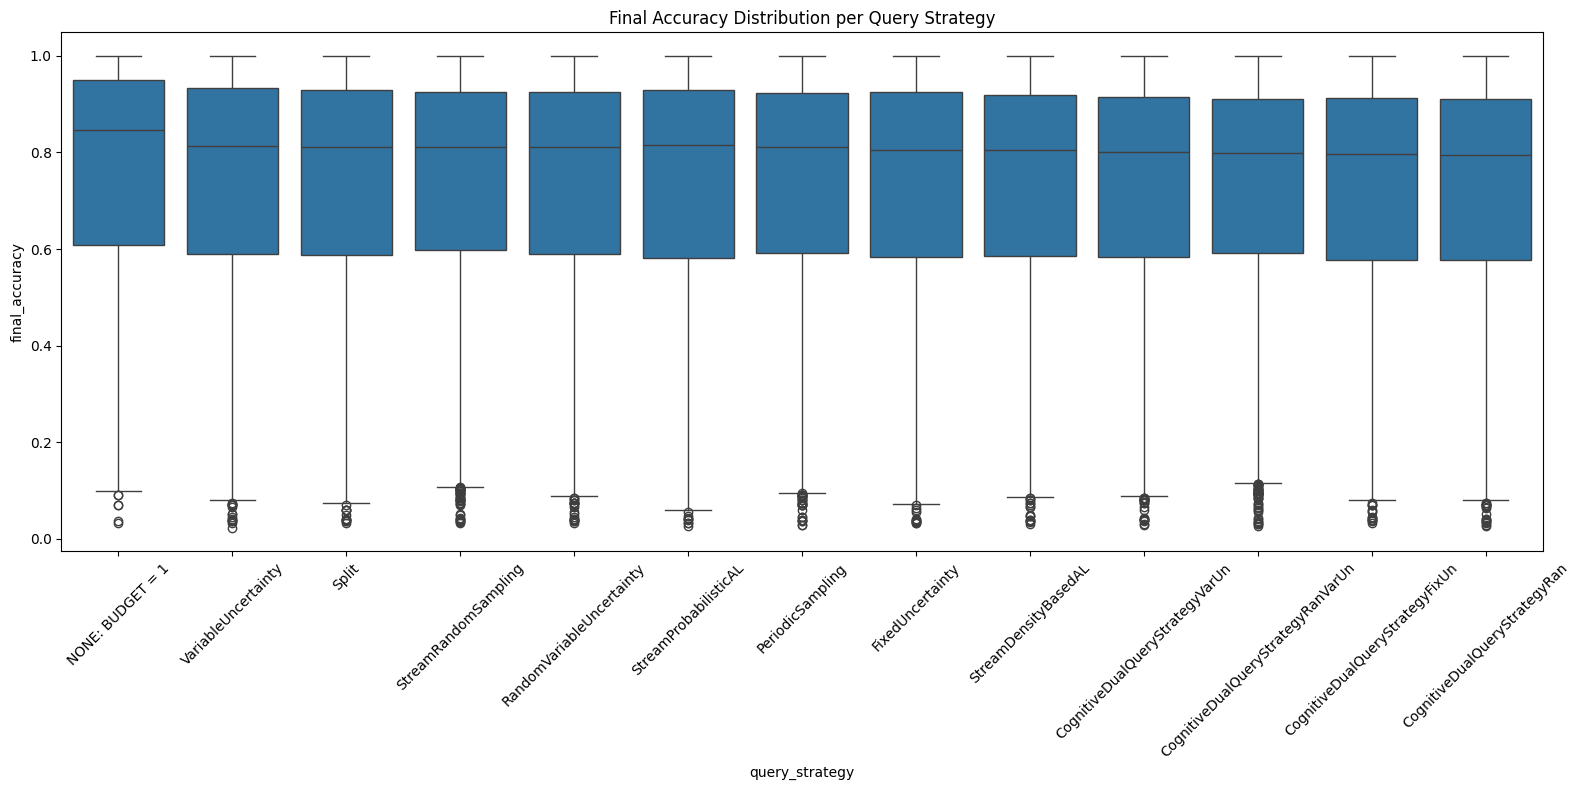

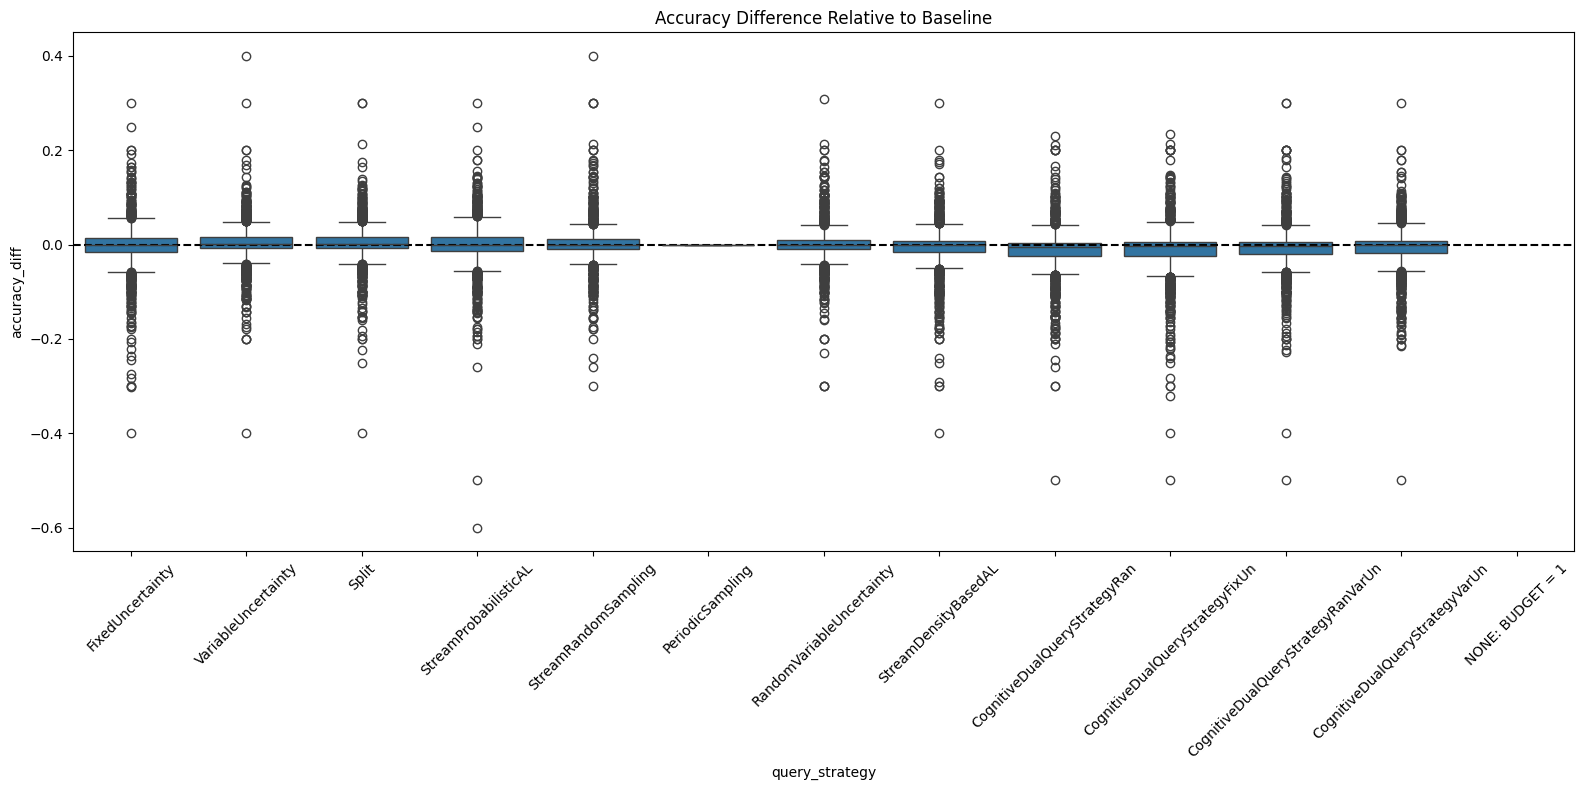

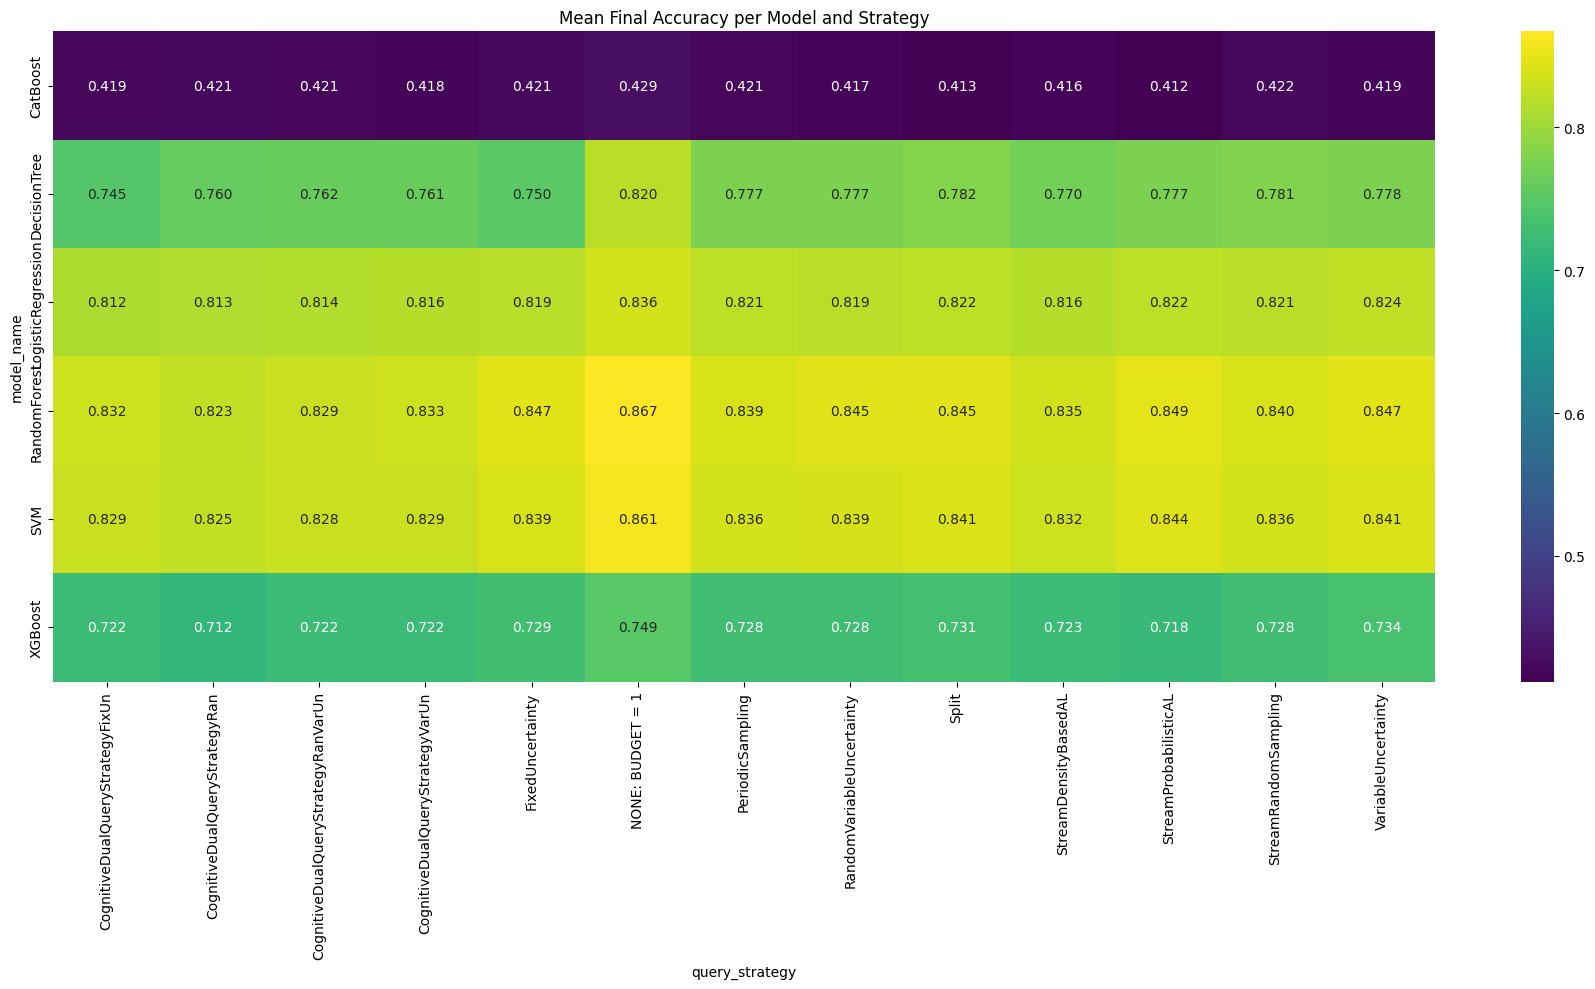

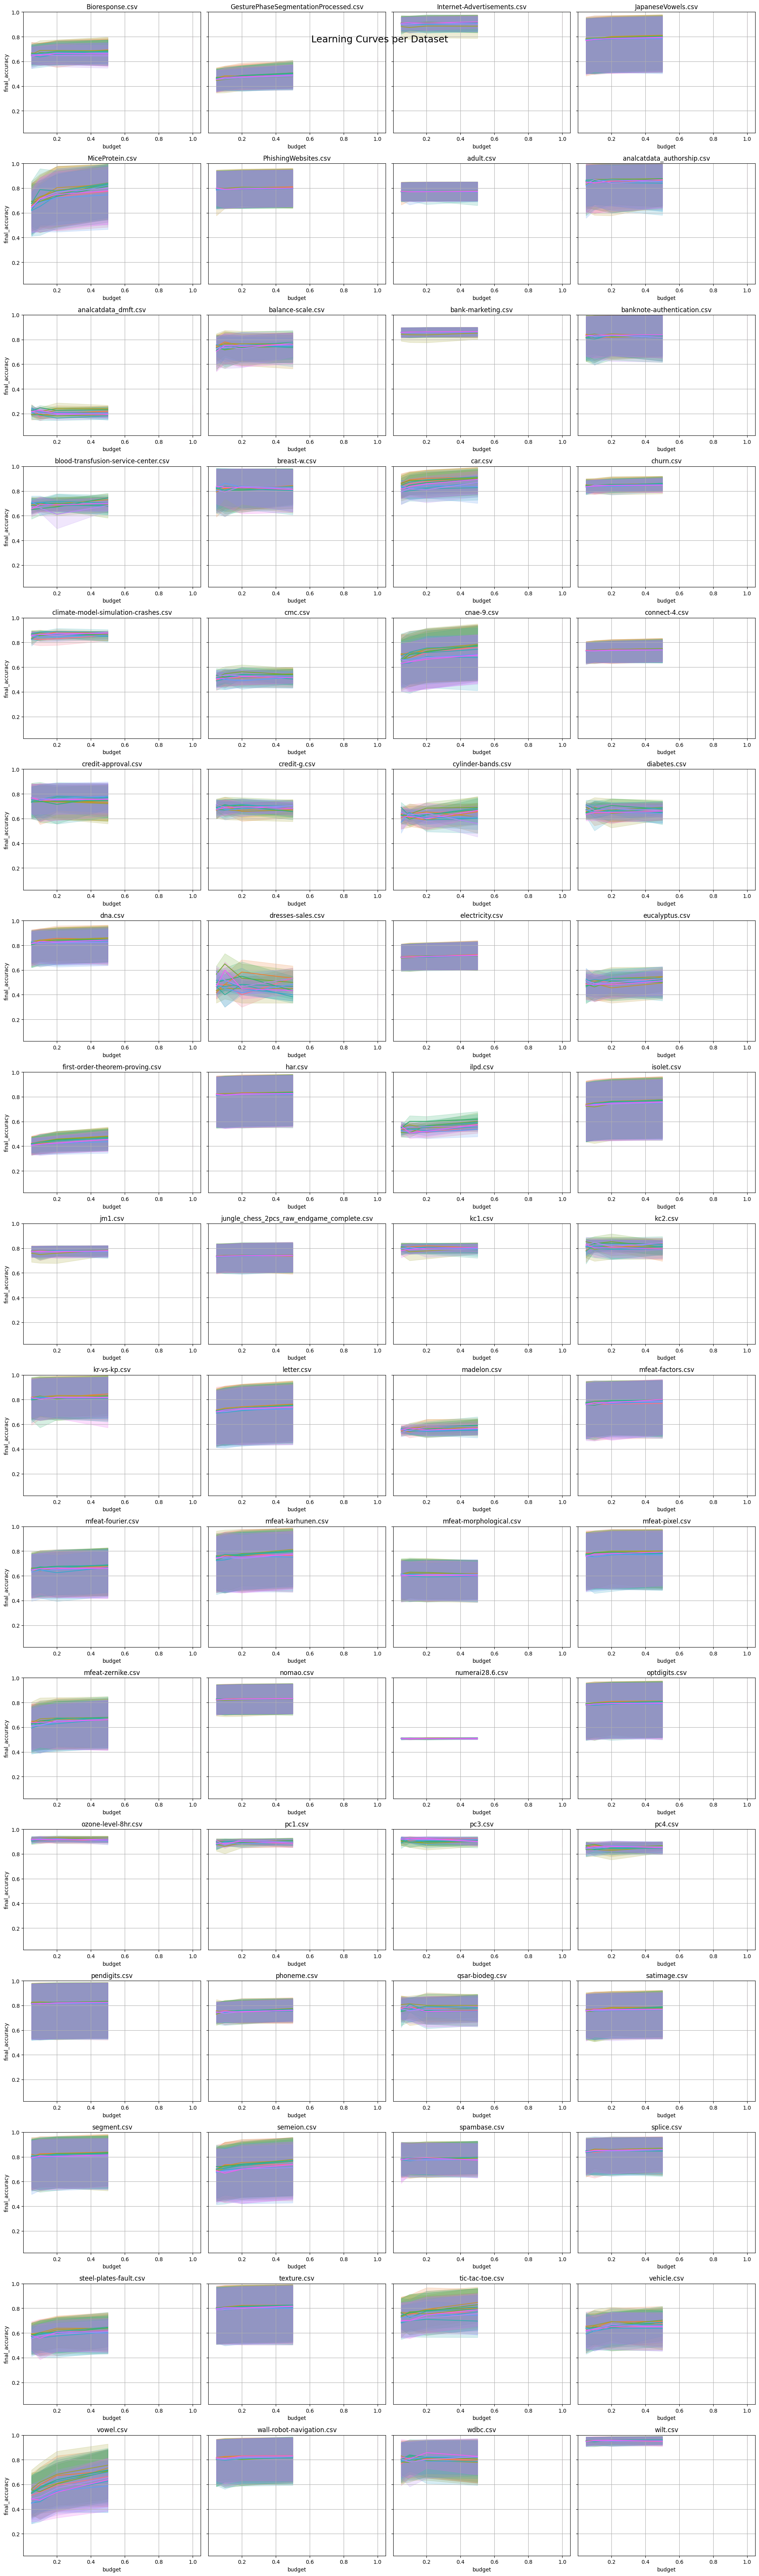

In [3]:
plot_learning_curves(df_cc18)
plot_strategy_boxplots(df_cc18)
df_diff = compute_baseline_diff(df_cc18)
plot_accuracy_diff(df_diff)
plot_heatmap_model_strategy(df_cc18)
plot_dataset_grid(df_cc18)

In [4]:
df_cc18.columns

Index(['dataset', 'model_name', 'model_params', 'initial_score',
       'query_strategy', 'budget', 'percentage_queried', 'final_accuracy'],
      dtype='object')

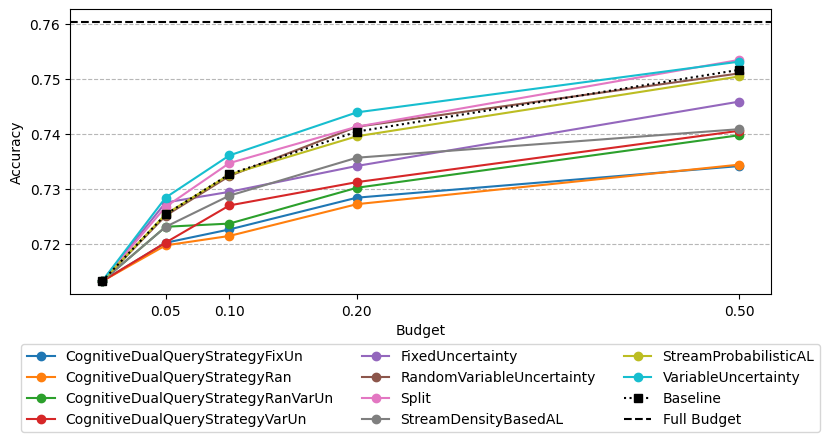

In [5]:
df_cc18_general = (
    df_cc18[["query_strategy", "budget", "initial_score", "final_accuracy"]]
    .groupby(["query_strategy", "budget"], as_index=False)
    .mean()
)

strategies_to_merge = ["PeriodicSampling", "StreamRandomSampling"]

df_baseline = df_cc18_general[
    df_cc18_general["query_strategy"].isin(strategies_to_merge)
]

df_baseline = df_baseline.groupby("budget", as_index=False).agg(
    {"initial_score": "mean", "final_accuracy": "mean"}
)

df_baseline["query_strategy"] = "Baseline"

df_new = pd.concat([df_cc18_general, df_baseline], ignore_index=True)

plt.figure(figsize=(8, 5))

for strategy in df_new["query_strategy"].unique():
    if strategy not in ["NONE: BUDGET = 1", "PeriodicSampling", "StreamRandomSampling"]:
        data = df_new[df_new["query_strategy"] == strategy]

        budget_0_dict = {
            "query_strategy": strategy,
            "budget": 0,
            "initial_score": [data["initial_score"].mean()],
            "final_accuracy": [data["initial_score"].mean()],
        }
        budget_0_df = pd.DataFrame(budget_0_dict)
        data = pd.concat([data, budget_0_df], axis=0).sort_values(
            by="budget", ascending=True
        )

        x = data["budget"]
        y = data["final_accuracy"]

        if strategy == "Baseline":
            plt.plot(x, y, label=strategy, marker="s", linestyle=":", color="black")
        else:
            plt.plot(x, y, label=strategy, marker="o")
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
        plt.xlabel("Budget")
        plt.ylabel("Accuracy")
        plt.xticks([0.05, 0.1, 0.2, 0.5])
        plt.grid(axis="y", linestyle="--", alpha=0.9)
        plt.tight_layout()

constant_value = df_new[df_new["query_strategy"] == "NONE: BUDGET = 1"][
    "final_accuracy"
].values[0]

plt.axhline(y=constant_value, color="black", linestyle="--", label="Full Budget")

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [6]:
baseline_strategies = ["PeriodicSampling", "StreamRandomSampling"]

baseline_data = {
    b: df_cc18[df_cc18["query_strategy"] == b]["final_accuracy"].dropna()
    for b in baseline_strategies
}

other_strategies = [
    s for s in df_cc18["query_strategy"].unique() 
    if s not in baseline_strategies
]

results = []

for baseline in baseline_strategies:
    for strategy in other_strategies:
        acc_base = baseline_data[baseline]
        acc_other = df_cc18[df_cc18["query_strategy"] == strategy]["final_accuracy"].dropna()

        # Welch’s t-test (does not assume equal variance)
        stat, p_value = ttest_ind(acc_other, acc_base, equal_var=False)

        results.append({
            "baseline": baseline,
            "strategy": strategy,
            "p_value": p_value
        })

# Convert to a dataframe of results
df_pvalues = pd.DataFrame(results)
print(df_pvalues)


                baseline                            strategy   p_value
0       PeriodicSampling                    FixedUncertainty  0.744226
1       PeriodicSampling                 VariableUncertainty  0.677570
2       PeriodicSampling                               Split  0.800221
3       PeriodicSampling               StreamProbabilisticAL  0.995118
4       PeriodicSampling           RandomVariableUncertainty  0.952658
5       PeriodicSampling                StreamDensityBasedAL  0.556744
6       PeriodicSampling       CognitiveDualQueryStrategyRan  0.169790
7       PeriodicSampling     CognitiveDualQueryStrategyFixUn  0.197248
8       PeriodicSampling  CognitiveDualQueryStrategyRanVarUn  0.343612
9       PeriodicSampling     CognitiveDualQueryStrategyVarUn  0.381926
10      PeriodicSampling                    NONE: BUDGET = 1  0.079202
11  StreamRandomSampling                    FixedUncertainty  0.642163
12  StreamRandomSampling                 VariableUncertainty  0.782145
13  St

# Synth MOA

In [7]:
df_synth_moa = pd.read_csv("../data/final_results/synth_moa_concat.csv")
df_synth_moa.drop(columns="Unnamed: 0", inplace=True)
df_synth_moa.shape

(2940, 8)

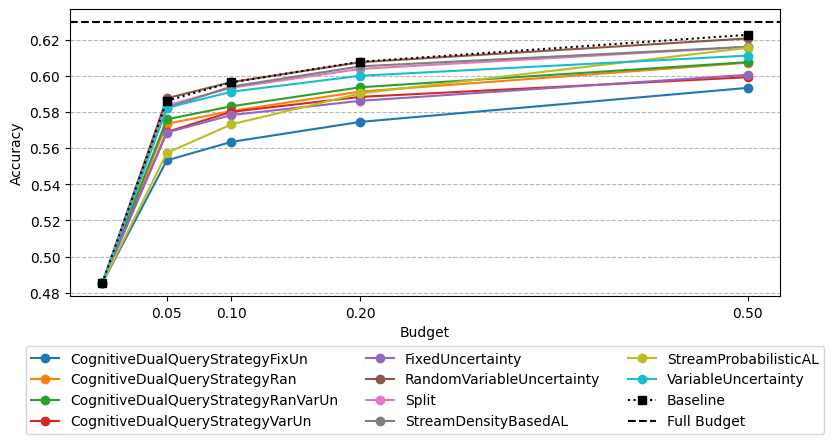

In [8]:
df_synth_moa_general = (
    df_synth_moa[["query_strategy", "budget", "initial_score", "final_accuracy"]]
    .groupby(["query_strategy", "budget"], as_index=False)
    .mean()
)

strategies_to_merge = ["PeriodicSampling", "StreamRandomSampling"]

df_baseline = df_synth_moa_general[
    df_synth_moa_general["query_strategy"].isin(strategies_to_merge)
]

df_baseline = df_baseline.groupby("budget", as_index=False).agg(
    {"initial_score": "mean", "final_accuracy": "mean"}
)

df_baseline["query_strategy"] = "Baseline"

df_new = pd.concat([df_synth_moa_general, df_baseline], ignore_index=True)

plt.figure(figsize=(8, 5))

for strategy in df_new["query_strategy"].unique():
    if strategy not in ["NONE: BUDGET = 1", "PeriodicSampling", "StreamRandomSampling"]:
        data = df_new[df_new["query_strategy"] == strategy]

        budget_0_dict = {
            "query_strategy": strategy,
            "budget": 0,
            "initial_score": [data["initial_score"].mean()],
            "final_accuracy": [data["initial_score"].mean()],
        }
        budget_0_df = pd.DataFrame(budget_0_dict)
        data = pd.concat([data, budget_0_df], axis=0).sort_values(
            by="budget", ascending=True
        )

        x = data["budget"]
        y = data["final_accuracy"]

        if strategy == "Baseline":
            plt.plot(x, y, label=strategy, marker="s", linestyle=":", color="black")
        else:
            plt.plot(x, y, label=strategy, marker="o")
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
        plt.xlabel("Budget")
        plt.ylabel("Accuracy")
        plt.xticks([0.05, 0.1, 0.2, 0.5])
        plt.grid(axis="y", linestyle="--", alpha=0.9)
        plt.tight_layout()

constant_value = df_new[df_new["query_strategy"] == "NONE: BUDGET = 1"][
    "final_accuracy"
].values[0]

plt.axhline(y=constant_value, color="black", linestyle="--", label="Full Budget")

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [9]:
baseline_strategies = ["PeriodicSampling", "StreamRandomSampling"]

baseline_data = {
    b: df_synth_moa[df_synth_moa["query_strategy"] == b]["final_accuracy"].dropna()
    for b in baseline_strategies
}

other_strategies = [
    s for s in df_synth_moa["query_strategy"].unique() 
    if s not in baseline_strategies
]

results = []

for baseline in baseline_strategies:
    for strategy in other_strategies:
        acc_base = baseline_data[baseline]
        acc_other = df_synth_moa[df_synth_moa["query_strategy"] == strategy]["final_accuracy"].dropna()

        # Welch’s t-test (does not assume equal variance)
        stat, p_value = ttest_ind(acc_other, acc_base, equal_var=False)

        results.append({
            "baseline": baseline,
            "strategy": strategy,
            "p_value": p_value
        })

# Convert to a dataframe of results
df_pvalues = pd.DataFrame(results)
print(df_pvalues)


                baseline                            strategy   p_value
0       PeriodicSampling                    FixedUncertainty  0.375626
1       PeriodicSampling                 VariableUncertainty  0.744542
2       PeriodicSampling                               Split  0.847221
3       PeriodicSampling               StreamProbabilisticAL  0.383797
4       PeriodicSampling           RandomVariableUncertainty  0.980273
5       PeriodicSampling                StreamDensityBasedAL  0.854764
6       PeriodicSampling       CognitiveDualQueryStrategyRan  0.503260
7       PeriodicSampling     CognitiveDualQueryStrategyFixUn  0.152572
8       PeriodicSampling  CognitiveDualQueryStrategyRanVarUn  0.558141
9       PeriodicSampling     CognitiveDualQueryStrategyVarUn  0.392443
10      PeriodicSampling                    NONE: BUDGET = 1  0.480790
11  StreamRandomSampling                    FixedUncertainty  0.394521
12  StreamRandomSampling                 VariableUncertainty  0.770521
13  St

# Real MOA

In [10]:
df_real_moa = pd.read_csv("../data/final_results/real_moa_concat.csv")
df_real_moa.drop(columns="Unnamed: 0", inplace=True)
df_real_moa.shape

(1176, 8)

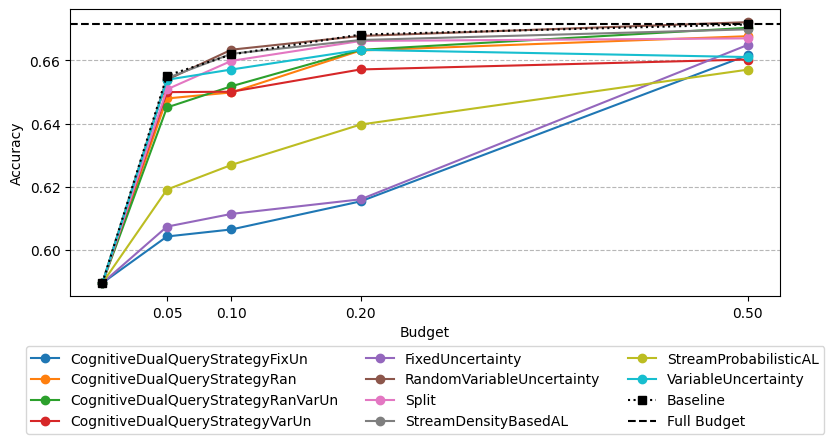

In [11]:
df_real_moa_general = (
    df_real_moa[["query_strategy", "budget", "initial_score", "final_accuracy"]]
    .groupby(["query_strategy", "budget"], as_index=False)
    .mean()
)

strategies_to_merge = ["PeriodicSampling", "StreamRandomSampling"]

df_baseline = df_real_moa_general[
    df_real_moa_general["query_strategy"].isin(strategies_to_merge)
]

df_baseline = df_baseline.groupby("budget", as_index=False).agg(
    {"initial_score": "mean", "final_accuracy": "mean"}
)

df_baseline["query_strategy"] = "Baseline"

df_new = pd.concat([df_real_moa_general, df_baseline], ignore_index=True)

plt.figure(figsize=(8, 5))

for strategy in df_new["query_strategy"].unique():
    if strategy not in ["NONE: BUDGET = 1", "PeriodicSampling", "StreamRandomSampling"]:
        data = df_new[df_new["query_strategy"] == strategy]

        budget_0_dict = {
            "query_strategy": strategy,
            "budget": 0,
            "initial_score": [data["initial_score"].mean()],
            "final_accuracy": [data["initial_score"].mean()],
        }
        budget_0_df = pd.DataFrame(budget_0_dict)
        data = pd.concat([data, budget_0_df], axis=0).sort_values(
            by="budget", ascending=True
        )

        x = data["budget"]
        y = data["final_accuracy"]

        if strategy == "Baseline":
            plt.plot(x, y, label=strategy, marker="s", linestyle=":", color="black")
        else:
            plt.plot(x, y, label=strategy, marker="o")
        plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=2)
        plt.xlabel("Budget")
        plt.ylabel("Accuracy")
        plt.xticks([0.05, 0.1, 0.2, 0.5])
        plt.grid(axis="y", linestyle="--", alpha=0.9)
        plt.tight_layout()

constant_value = df_new[df_new["query_strategy"] == "NONE: BUDGET = 1"][
    "final_accuracy"
].values[0]

plt.axhline(y=constant_value, color="black", linestyle="--", label="Full Budget")

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3)

plt.show()

In [12]:
baseline_strategies = ["PeriodicSampling", "StreamRandomSampling"]

baseline_data = {
    b: df_real_moa[df_real_moa["query_strategy"] == b]["final_accuracy"].dropna()
    for b in baseline_strategies
}

other_strategies = [
    s for s in df_real_moa["query_strategy"].unique() 
    if s not in baseline_strategies
]

results = []

for baseline in baseline_strategies:
    for strategy in other_strategies:
        acc_base = baseline_data[baseline]
        acc_other = df_real_moa[df_real_moa["query_strategy"] == strategy]["final_accuracy"].dropna()

        # Welch’s t-test (does not assume equal variance)
        stat, p_value = ttest_ind(acc_other, acc_base, equal_var=False)

        results.append({
            "baseline": baseline,
            "strategy": strategy,
            "p_value": p_value
        })

# Convert to a dataframe of results
df_pvalues = pd.DataFrame(results)
print(df_pvalues)


                baseline                            strategy   p_value
0       PeriodicSampling                    FixedUncertainty  0.123479
1       PeriodicSampling                 VariableUncertainty  0.853172
2       PeriodicSampling                               Split  0.920245
3       PeriodicSampling               StreamProbabilisticAL  0.269530
4       PeriodicSampling           RandomVariableUncertainty  0.973269
5       PeriodicSampling                StreamDensityBasedAL  0.992074
6       PeriodicSampling       CognitiveDualQueryStrategyRan  0.799301
7       PeriodicSampling     CognitiveDualQueryStrategyFixUn  0.095474
8       PeriodicSampling  CognitiveDualQueryStrategyRanVarUn  0.814491
9       PeriodicSampling     CognitiveDualQueryStrategyVarUn  0.712593
10      PeriodicSampling                    NONE: BUDGET = 1  0.841834
11  StreamRandomSampling                    FixedUncertainty  0.110291
12  StreamRandomSampling                 VariableUncertainty  0.808221
13  St

## Union

In [22]:
df_union = pd.concat(
    [df_cc18, df_synth_moa, df_real_moa],
    axis=0,
    ignore_index=True
)
df_union.shape

(24108, 8)

In [23]:
df_union_new = unify_query_strategies(df_union)

In [24]:
df_union_new

,dataset,model_name,model_params,initial_score,query_strategy,budget,percentage_queried,final_accuracy
0,Bioresponse.csv,LogisticRegression,{'C': 0.001},0.704000,FixedUncertainty,0.05,0.052982,0.736000
1,Bioresponse.csv,LogisticRegression,{'C': 0.001},0.704000,VariableUncertainty,0.05,0.055648,0.712000
2,Bioresponse.csv,LogisticRegression,{'C': 0.001},0.704000,Split,0.05,0.055648,0.744000
3,Bioresponse.csv,LogisticRegression,{'C': 0.001},0.704000,StreamProbabilisticAL,0.05,0.050317,0.717333
4,Bioresponse.csv,LogisticRegression,{'C': 0.001},0.704000,RandomVariableUncertainty,0.05,0.055648,0.717333
...,...,...,...,...,...,...,...,...
24043,wilt.csv,XGBoost,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.894628,Baseline,0.10,0.109532,0.913223
24044,wilt.csv,XGBoost,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.894628,Baseline,0.20,0.199948,0.900826
24045,wilt.csv,XGBoost,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.894628,Baseline,0.20,0.206923,0.876033
24046,wilt.csv,XGBoost,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.894628,Baseline,0.50,0.495996,0.892562



--- Calculated P-Values (vs. Baseline) ---
{'FixedUncertainty': '0.3054', 'VariableUncertainty': '0.8244', 'Split': '0.9000', 'StreamProbabilisticAL': '0.5545', 'RandomVariableUncertainty': '0.9828', 'StreamDensityBasedAL': '0.4709', 'CognitiveDualQueryStrategyRan': '0.0743', 'CognitiveDualQueryStrategyFixUn': '0.0233', 'CognitiveDualQueryStrategyRanVarUn': '0.1916', 'CognitiveDualQueryStrategyVarUn': '0.1721', 'NONE: BUDGET = 1': '0.0518', 'Baseline': '1.0000'}
------------------------------------------


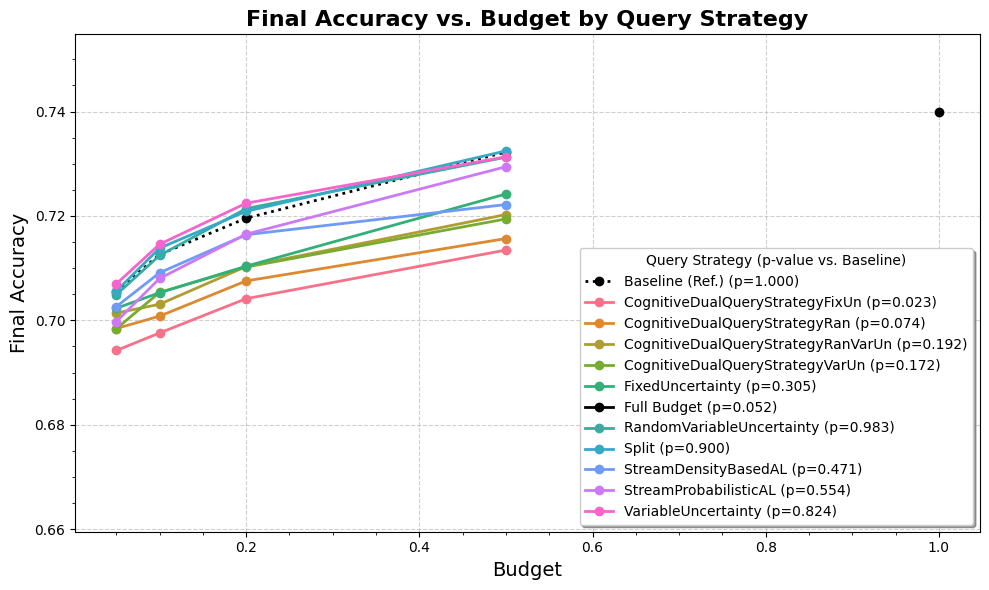

In [42]:
plot_accuracy_vs_budget(df_union_new, calculate_p_values(df_union_new))